# Deep Convolutional Generative Adversarial Network

In [42]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import random

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-eoli8hjz
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-eoli8hjz
  Resolved https://github.com/tensorflow/docs to commit 8246c1cba26bb07d9c02c165d83936c5b50825ca
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.12.6.69331-py3-none-any.whl size=181263 sha256=ce463b7023f790197078e9c69ae956cf615151589a2f0112ea63b01744660121
  Stored in directory: /tmp/pip-ephem-wheel-cache-x_twqywk/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


### Load and prepare the dataset



In [6]:
import zipfile
import os

zip_file_path = 'processed-celeba-small.zip'
output_folder = '/content'

os.makedirs(output_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print(f"The contents of {zip_file_path} have been extracted to {output_folder}.")

The contents of processed-celeba-small.zip have been extracted to /content.


In [5]:
def readImage(path,image_size=(64,64)):
    img = np.asarray(PIL.Image.open(path).resize(image_size))
    img = img/255
    return img

In [7]:
image_paths = glob('processed_celeba_small/celeba'+"/*")
image_paths2 = glob('processed_celeba_small/celeba/New Folder With Items'+"/*")
for path in image_paths[:]:  # Create a copy of the list to iterate over
    if path == 'processed_celeba_small/celeba/New Folder With Items':
        image_paths.remove(path)

In [8]:
image_paths = image_paths + image_paths2

In [10]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(image_paths) // BATCH_SIZE
print("Steps per epochh are",STEPS_PER_EPOCH)
def dataGenerator(batch_size):
    while True:
        # Shuffle the list of image paths
        random.shuffle(image_paths)
        # Iterate over batches
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch = [readImage(p) for p in batch_paths]
            yield np.asarray(batch)

dataGen = dataGenerator(BATCH_SIZE)
print(next(dataGen).shape)

Steps per epochh are 1405
(64, 64, 64, 3)


## Create the models



### The Generator



In [18]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8,8, 256)))

    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), use_bias=False, padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None, 16, 16, 128)

    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), use_bias=False, padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None, 32, 32, 128)

    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=False, padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None, 64, 64, 64)

    
    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), use_bias=False, padding="same", kernel_initializer=WEIGHT_INIT, activation="sigmoid"))

    assert model.output_shape == (None, 64, 64, 3)

    return model

Use the (as yet untrained) generator to create an image.

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


TensorShape([1, 64, 64, 3])

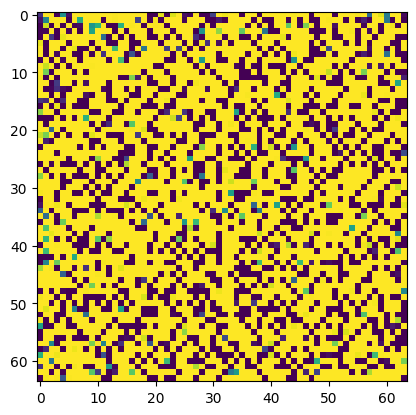

In [20]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
generated_image.shape

### The Discriminator

The discriminator is a CNN-based image classifier.

In [24]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(64,64,3)))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(512,(5,5),strides=(2,2),padding="same"))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [25]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.01261099]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [31]:
EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print("here")
    for step in range(STEPS_PER_EPOCH):
        train_step(next(dataset))

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [34]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # predictions.shape[0]
      # plt.imshow(predictions[i, :, :, :].numpy().astype("uint8") * 255+255)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**Generate and save images**


## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

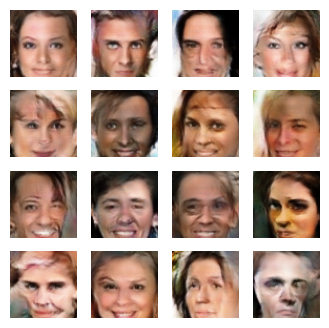

In [36]:
train(dataGen, EPOCHS)

Restore the latest checkpoint.

In [37]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [44]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [45]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [48]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-48-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-48-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



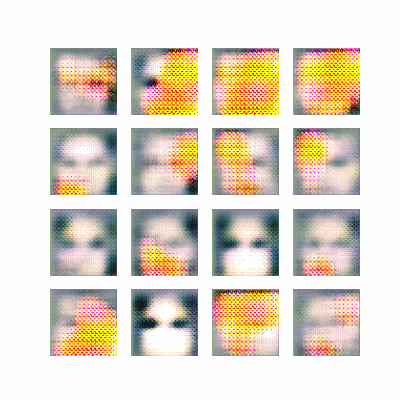

In [49]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

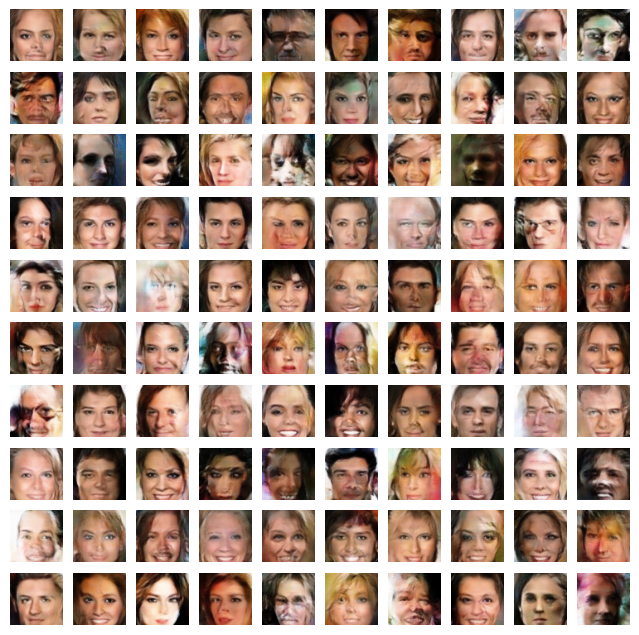

In [55]:
tf.random.set_seed(1234)

num_samples = 100  
random_noise = tf.random.normal(shape=[num_samples, noise_dim])


generated_images = generator(random_noise, training=False)

fig = plt.figure(figsize=(8, 8))
for i in range(generated_images.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')

plt.show()